# Computing the expected information density in the Ergodic Information Harvesting algorithm
This is a tutorial on how to compute the expected information density, a key element of the EIH. Once it is computed, a trajectory that balances energy expenditure with ergodicity is generated as described in the Supplement, moving the measuring or sensing system so as to gamble on the information represented by the EID through motion. 

Chen Chen & Malcolm MacIver & Todd Murphey

August 2019

## Table of Contents
1. [Example Description](#0.-Example-Description)
2. [Observation Model](#2.-Observation-Model)
3. [Likelihood](#3.-Likelihood)
4. [Bayesian Filter](#4.-Bayesian-Filter)
5. [Expected Information Density](#5.-Expected-Information-Density)

***

## 1. Example Description
To start our tutorial, let's define a scenario. Imagine we have a robot equipped with a microphone capable of moving along a line. There is a stationary buzzer that generates a fixed-intensity sound located in the same space. The microphone on the robot only gives the loudness of the sound it picks up—ignoring pitch. The task here is to move the robot along the 1D axis to take measurements and use them to estimate the location of the buzzer.

## 2. Observation Model

For the sake of simplicity, let's say our robot can only move between 0 to 1. We can represent the scenario as:

- A sensor (microphone), with location denoted by $x$, can move freely within 1D space $x \in \mathbb{X}=[0, 1]$
- A signal source (buzzer) is fixed at a particular location within the 1D space $\theta \in [0, 1]$
- The sensor's measurement of sound loudness is denoted by $V \in \mathbb{V} = [0, 1]$

An observation model relates measured signals to random variables. The observation model, in our case, relates the measured **loudness of sound** to the **location of the sound source (buzzer)**. For example, receiving a numerical measurement of $V=0.5$ does not give us any information about where the sound source is *unless we have an observation model of our sensor*.

In [1]:
# import libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.pyplot import plot
from scipy.stats import norm, entropy, recipinvgauss
from scipy.interpolate import interp1d
from scipy.signal import convolve

# Configure Matplotlib
%matplotlib inline

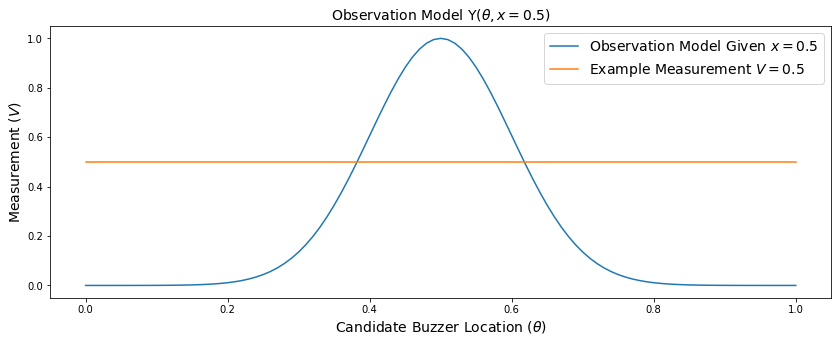

In [2]:
# workspace spec
wsResolution = 101 # resolution
wsSamples = np.linspace(0, 1, wsResolution)

# observation model
def Upsilon(theta=0.5, sigmaM=0.1):
    if type(theta) is float:
        mm = norm.pdf(wsSamples,theta,sigmaM)
        mm /= max(mm)
    else:
        # query multiple possible target theta
        mm = []
        for t in theta:
            mm_ = norm.pdf(wsSamples,t,sigmaM)
            mm_ /= max(mm_)
            mm.append(mm_)
        mm = np.array(mm)
    return mm
  
# Visualize an observation model
plt.figure(figsize=(14,5));
plot(wsSamples, Upsilon(0.5));
plot(wsSamples, np.tile([0.5], wsResolution))
plt.legend((r'Observation Model Given $x = 0.5$', 'Example Measurement $V = 0.5$'), fontsize=14, loc='best')
plt.xlabel(r'Candidate Buzzer Location ($\theta$)', fontsize=14);
plt.ylabel('Measurement ($V$)', fontsize=14);
plt.title(r"Observation Model $\Upsilon(\theta, x = 0.5)$", fontsize=14);

The plot illustrates what an observation model might look like. Specifically, this is a Gaussian observation model. For our microphone and buzzer example, the plot assumes the sensor location is fixed at $x=0.5$, and predicts the sound intensity as a function of candidate buzzer location ($\theta$). 

When the buzzer's location is closer to the sensor at 0.5, we get a larger sensor reading, and the opposite happens when it is further away. Clearly, given a measurement of $V = 0.5$, the expected location of the source can be inferred from the observation model, but not uniquely. Drawing an orange line at $V=0.5$ in the same plot, we can find two possible solutions (the $\theta$ location at which the orange line crosses the blue curve).

## 3. Likelihood

Thus far the observation model itself has no uncertainty: if you receive a measurement $V=0.5$ as shown above, the target $\theta$ will be in one of the two possible locations, but whichever of the two it is, it is exactly the location given by the intersection of the orange and blue curves. In other words, the resulting solutions of $\theta$ that satistifies $\Upsilon(\theta, x = 0.5)=0.5$ is deterministic, though not unique. In engineered systems, one of the most common forms of uncertainty is measurement noise. Somewhere in the measurement process, either in the sensor itself or in the analog-to-digital converter we are using or something else (for example, a limited number of significant digits in the floating point numbers of the computer representing our measurements), uncertainty—often modeled as noise—will occur. In biological systems, sensory systems have a variety of uncertainty sources. In visual systems such as that of the moth tracking a flower in our study, there is motion blur (when an image passes over more than one photoreceptor acceptance angle per response time) and dark noise level (photoreceptor responses that seem like they are due to a photon but are not). In either case, instead of the sensor providing a response that matches the observation model, the sensor generates a reading that deviates from the prediction by some amount. Perhaps the simplest way to incorporate this uncertainty in the observations is with the addition of zero-mean Gaussian noise, as follows:
$$
V = \Upsilon(\theta, x) + \epsilon
$$
where $\Upsilon(\theta, x)$ is the observation model and $\epsilon$ represents the additive zero-mean Gaussian noise.

How should this uncertainty be represented in the process of inferring the distribution over the random variable (*i.e.*, the location of the target $\theta$) using the observation model? One method is to use a Gaussian likelihood function.

### Intuition for the Likelihood Function
The likelihood function does essentially the same operation as our example in the measurement plot of drawing a measurement line on top of the observation model to figure out where the target location is. The main difference is that the aformentioned approach assumes no uncertainty because we used only one solid line to represent a measurement. Given uncertainty, our measurement could be in the form of $V = 0.5\pm0.1$, where 0.5 is from the deterministic observation model and 0.1 comes from uncertainty. This is equivalent to drawing a series of lines within $0.5\pm0.1$ and using that to estimate a range of possible target locations. When the candidate buzzer location is represented by a probability density function $p(\theta)$ instead of a single value, the likelihood function is evaluated by taking all the $\theta$ and adding up the likelihoods of locations weighted by the likelihood of measurement $V$ given by $p(\theta)$.

For example:

The likelihood that the buzzer is located at 0.4
given a measurement V=0.625 at location x=0.5 is
	p(V = 0.625 | theta = 0.4, x = 0.5) = 0.0514


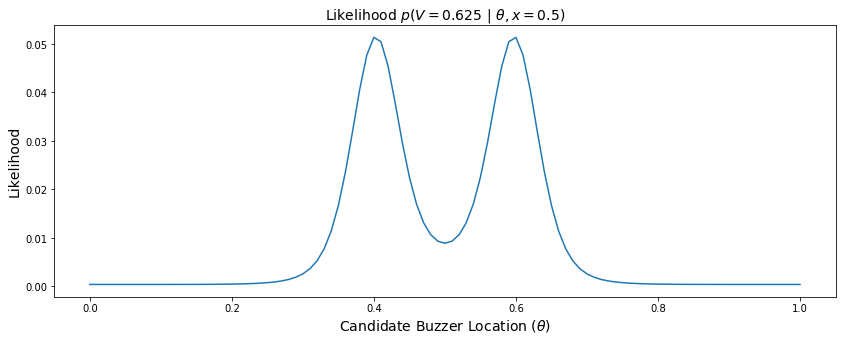

In [3]:
# likelihood function
def Pvtheta(v, theta, sigmaM=0.1, sigmaL=0.2):
    # Compute likelihood
    pvt = ( 1.0 / (np.sqrt(2.0*np.pi) * sigmaL) ) * np.exp( -(v - Upsilon(theta, sigmaM))**2 / (2.0 * sigmaL**2) )
    # Normalize
    if pvt.ndim == 1:
        return pvt / pvt.sum()
    else:
        for idx in range(pvt.shape[0]):
            pvt[idx, :] /= pvt[idx, :].sum()
    return pvt

# Visualize an example likelihood
plt.figure(figsize=(14,5))
plot(wsSamples, Pvtheta(0.625, 0.5))
plt.xlabel(r'Candidate Buzzer Location ($\theta$)', fontsize=14)
plt.ylabel(r'Likelihood', fontsize=14)
plt.title(r'Likelihood $p(V=0.625~|~\theta, x=0.5)$', fontsize=14)

print("For example:\n\nThe likelihood that the buzzer is located at 0.4\n"
      "given a measurement V=0.625 at location x=0.5 is\n"
      f"\tp(V = 0.625 | theta = 0.4, x = 0.5) = {Pvtheta(0.625, 0.5)[40]:.4f}")

## 4. Bayesian Filter

### Probability Distribution, Probability Density Function (Belief), and Entropy of the Belief
The goal of the example is to take consecutive measurements through the microphone to form an accurate estimate of the buzzer's location. Our robot's knowledge about the buzzer's location can be captured in a probability distribution. We can visualize this in the form of a probability density function (PDF) $p(\theta)$ where $\theta$ is the buzzer's location we are trying to estimate. The PDF is often referred to as the *belief* as it represents what the robot believes about the buzzer position for all possible candidate positions. Let's use an example to demonstrate what the belief PDF looks like and how it can be applied.

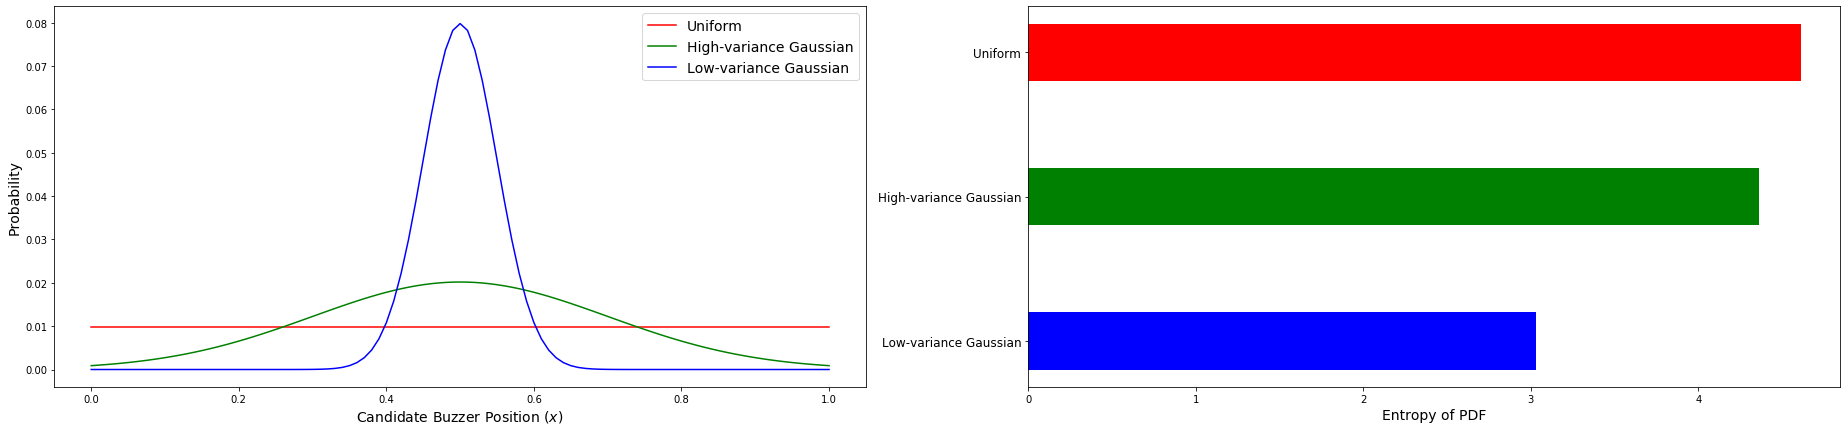

In [4]:
# Plot some PDF as example and their corresponding entropy
priorP1 = np.ones(wsResolution)/wsResolution # An uniform "uninformative" PDF
priorP3 = norm.pdf(wsSamples,0.5,0.2)        # A high-variance Gaussian PDF
priorP4 = norm.pdf(wsSamples,0.5,0.05)       # A low-variance Gaussian PDF
priorP1 /= priorP1.sum()
priorP3 /= priorP3.sum()
priorP4 /= priorP4.sum()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(32,7))
ax1.plot(wsSamples, priorP1, color='r')
ax1.plot(wsSamples, priorP3, color='g')
ax1.plot(wsSamples, priorP4, color='b')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Probability', fontsize=14)
ax1.legend(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
           fontsize=14, loc='best');

ax2.barh([0,1,2], [entropy(priorP1), entropy(priorP3), entropy(priorP4)], height=0.4, 
        color=['r', 'g', 'b'])
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
                   fontsize=12)
ax2.invert_yaxis()
ax2.set_xlabel(r'Entropy of PDF', fontsize=14);

The plot above shows three different belief PDFs. In our case, a belief is a function of candidate buzzer position as shown along the horizontal axis, with probability shown along the vertical axis. We encode knowledge of the buzzer's location through the belief. Three belief distributions are shown: 
- **Uniform** - The probability of every candidate buzzer position is equal. This essentially means that our robot knows nothing about the buzzer's location.
- **High-variance Gaussian** - Our robot has a rough clue that the buzzer should be near location $\theta=0.5$ because that's where the peak of the belief is, but the high variance of the PDF means the robot is not so sure about its guess.
- **Low-variance Gaussian** - Our robot has a fairly clear idea that the buzzer is around $\theta=0.5$.

Clearly, as we go from a uniform to low-variance Gaussian belief PDF, the robot gradually knows more about where the buzzer is. This gradual improvement can be quantified by measuring the entropy of the belief shown on the right panel. The entropy is highest with the uniform belief and gradually lowers as the variance lowers in the Gaussian case. The entropy of the belief provides a way for us to compare different beliefs in order to determine how good our current estimate is. The entropy of a belief is defined as
$$
S\left[p(\theta)\right] = -\sum_\theta p(\theta) \log p(\theta)
$$
where $p(\theta)$ is the belief. We will use entropy reduction as the criterion for making decisions about search.

### Recursive Bayesian Filtering
At this point, we have already defined:
- **The Observation Model $\Upsilon(\theta, x)$**, which captures how the sensor responds as a function of the position of the target. 
- **The Likelihood Function $p(V~\rvert~\theta, x)$**, which quantifies where the target is likely to be given a specific measurement.
- **The Belief $p(\theta)$**, which encodes all the information we know about the target's location in the form of a probability density function.

Let's say we begin with a uniform belief and let the robot take a measurement at its current location $x_0$. How do we use the likelihood function to update the belief? That's where the Bayesian filter kicks in:

$$
p(\theta~\rvert~V, x) = \dfrac{p(V~\rvert~\theta, x)~p(\theta)}{p(V~\rvert~x)} = \eta~p(V~\rvert~\theta, x)~p(\theta)
$$

where $p(V~\rvert~\theta, x)$ is the likelihood function, $p(\theta)$ is the prior belief (belief before update), $p(\theta~\rvert~V, x)$ is the posterior belief (belief after update), and $\eta = \frac{1}{p(V~\rvert~x)} = \frac{1}{\int_{\theta} p(V~\rvert~\theta,x)~p(\theta)d\theta}$ is a normalization factor that constrains the posterior belief $p(\theta~\rvert~V, x)$ to be a probability distribution. This equation shows how to update the belief using the likelihood function. We do this for each measurement.

## 5. Expected Information Density

At this point we know how to use sensor measurements to recursively update the belief. Do all sensor measurements have the same effect on our belief when used in the Bayesian filter? In other words, are all potential measurements equally informative? To answer this question, imagine two different scenarios where the robot potentially takes a measurement either at location $x=0$, or location $x=0.5$, yielding potential measurements $V_1$ and $V_2$, respectively. Based on a Gaussian prior belief $p(\theta)$ centered at 0.5 and the observation model, we compute the expectation $V_1\approx0$ and $V_2\approx1$. 

This tells us that $V_1$ will likely indicate that "the target is probably not here" and $V_2$ will likely indicate that "the target should be very close". Which measurement yields more information about the location of the target—in other words, a better posterior belief with lower entropy? If we calculate the expected entropy reduction for all posible sensor locations, we have a way of deciding what the next sensor location should be, by extremizing entropy reduction.

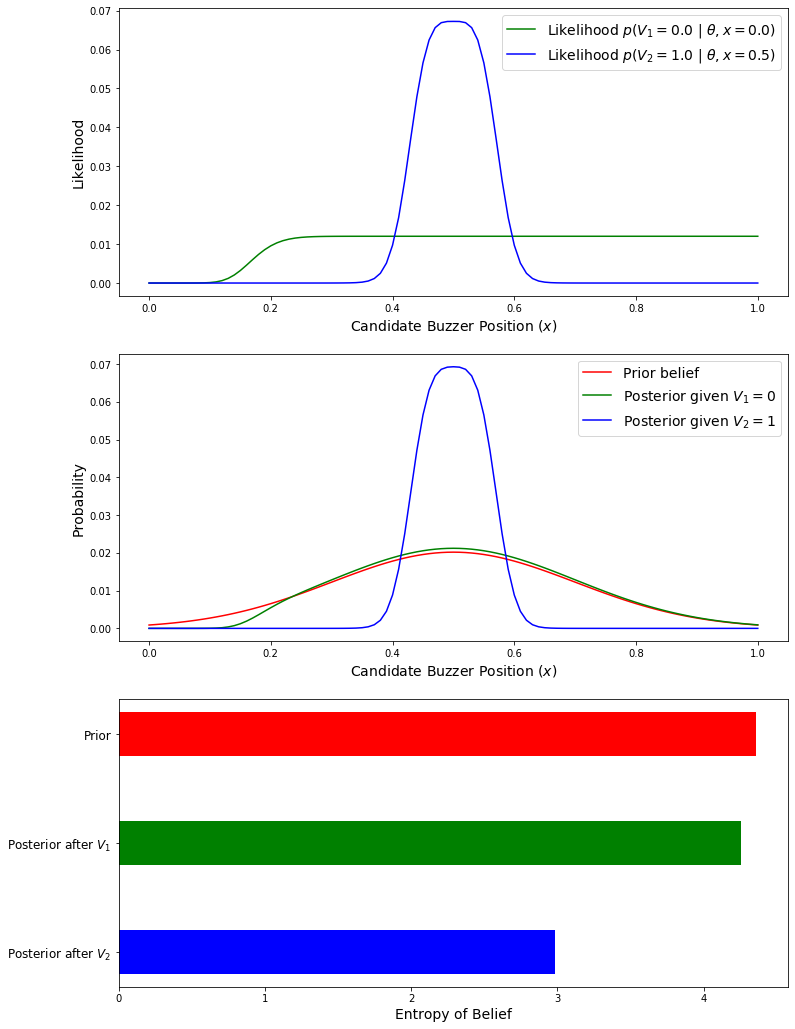

In [5]:
# Plot some PDF as example and their corresponding entropy
priorP1 = norm.pdf(wsSamples,0.5,0.2) # Gaussian belief
priorP1 /= priorP1.sum()

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
ax1.plot(wsSamples, Pvtheta(0.0, 0.0), color='g', label=r'Likelihood $p(V_1=0.0~|~\theta, x=0.0)$')
ax1.plot(wsSamples, Pvtheta(1.0, 0.5), color='b', label=r'Likelihood $p(V_2=1.0~|~\theta, x=0.5)$')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Likelihood', fontsize=14)
ax1.legend(fontsize=14, loc='best');

ppP1 = priorP1 * Pvtheta(0.0, 0.0)
ppP2 = priorP1 * Pvtheta(1.0, 0.5)
ppP1 /= ppP1.sum()
ppP2 /= ppP2.sum()

ax2.plot(wsSamples, priorP1, color='r', label='Prior belief')
ax2.plot(wsSamples, ppP1, color='g', label='Posterior given $V_1=0$')
ax2.plot(wsSamples, ppP2, color='b', label='Posterior given $V_2=1$')
ax2.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax2.set_ylabel(r'Probability', fontsize=14)
ax2.legend(fontsize=14, loc='best');

ax3.barh([0,1,2], [entropy(priorP1), entropy(ppP1), entropy(ppP2)], height=0.4, 
        color=['r', 'g', 'b'])
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(('Prior', 'Posterior after $V_1$', 'Posterior after $V_2$'), 
                   fontsize=12)
ax3.invert_yaxis()
ax3.set_xlabel(r'Entropy of Belief', fontsize=14);

Clearly, $V_2$ wins. The entropy of the posterior belief after getting measurement $V_2$ leads to a much lower entropy when compared to $V_1$. This example tells us two main messages:
1. Not all measurements are equally informative. Some measurements are more informative than others because they rule out more of the potential locations of the target.
2. Entropy of the belief can be used to evaluate how informative a measurement is, with an expectation of lower entropy after taking a measurement indicating that the measurement is correspondingly more informative.

It definitely sounds silly to let the robot randomly sample the entire workspace. It also does not sound right for the robot to take a measurement at a fixed location no matter what. Given the current belief, is there any good strategy that can help the sensor predict which location could lead to more informative measurement? The answer is yes and it involves the use the expected entropy reduction to form an expected information density (EID) map.

### Computing the Expected Information Density

Given $p(\theta)$, we want to compute for each $x$ the expected amount of information anticipated as a result of visiting location $x$. Let's try to break this down step-by-step:

1. Define observation model $\Upsilon(\theta,x)$, measurement $V = \Upsilon(\theta,x) + \epsilon$ (note that the sensor does not know $\theta$, the synthesis of each measurement is taken care of by the simulation, the sensor simply ask for a new measurement), and Gaussian likelihood function:
    $$
    p(V~\rvert~\theta, x) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\left[-\frac{(V-\Upsilon(\theta,x))^2}{2\sigma^2}\right]}
    $$

2. With a predicted distribution of measurements for each choice of $x$ from the likelihood function $p(V~\rvert~\theta,x)$, we then evaluate what the expected new posterior belief $p(\theta~\rvert~V,x)$ is if the sensor were to take a potential measurement at a given location $x$ in the workspace. For each choice of potential $x$ where a sensor measurement could be taken, the new posterior is computed by applying the Bayesian update rule.
    $$
    p(\theta~\rvert~V, x) = \eta~p(V~\rvert~\theta, x)~p(\theta)
    $$
    
3. Given a posterior belief $p(\theta~\rvert~V, x)$ evaluated on a potential $V$ measured at a potential location $x$, the entropy reduction from the prior belief $p(\theta)$ can be evaluated using:
    $$
    \Delta \text{S}(V, x) = \text{S} \left[ p(\theta) \right] - \text{S} \left[ p(\theta~\rvert~V, x) \right]
    $$
    where $S\left[ p(\theta) \right] \in \mathbb{R}^1$ and $S\left[ p(\theta) \right] = - \sum_{\theta} p(\theta)~\log p(\theta)$ is the Shannon-Weaver entropy of the prior belief $p(\theta)$, while $S \left[ p(\theta~\rvert~V, x) \right]$ is the Shannon-Weaver entropy of the posterior belief.

4. For any given prior belief $p(\theta)$, the probability of the sensor receiving a measurement $V$ given a choice of sensing location $x$ is not necessarily constant. Therefore, to evaluate the expected entropy reduction at a given sensing location $x$, the entropy reduction $\Delta S(V, x)$ needs to be weighted by the measurement probability $p(V~\rvert~x)$ that is consistent with the prior belief $p(\theta)$. This weighted probability can be obtained by applying the law of total probability to the normalized likelihood function $p(V~\rvert~\theta, x)$ treated as a probability distribution.
	$$
	p(V~\rvert~x) = \int_{\theta} p(\theta)p(V~\rvert~\theta, x) d\theta
	$$

5. Finally, the expected information density at location $x$&#151;$\text{EID}(x)$&#151;is obtained by computing the mathematical expectation of the entropy reduction *if one were* to take a measurement at location $x$. That is, $\text{EID}(x)$ is the weighted average entropy reduction resulting from the conditional probability $p(\theta~\rvert~V, x)$, weighted by the measurement probability $p(V~\rvert~x)$.
	$$
	\text{EID}(x) = \text{E} \left[ \Delta S(x) \right] = \int_V p(V~\rvert~x)~\Delta S(V, x) dV
	$$

To illustrate the calculation, we will show the EID for a given belief distribution $p(\theta)$, in this case an imagined multi-peak distribution. Recall from the start of the tutorial that the sensor's measurement of sound loudness is denoted by $V \in \mathbb{V} = [0, 1]$.

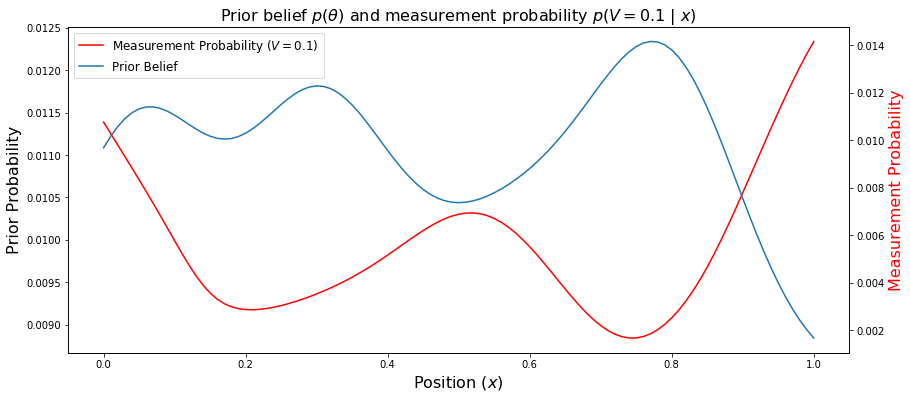

In [6]:
# Construct an arbitrary complex prior belief
priorP = norm.pdf(wsSamples,0.8,0.1) + \
         norm.pdf(wsSamples,0.3,0.1) + \
         norm.pdf(wsSamples,0.05,0.1) + \
         norm.pdf(wsSamples,0.6,0.15) 
priorP /= sum(priorP)


# Compute likelihood Pvx
def PvxNew(v, theta=wsSamples, prior=priorP, sigmaM=0.1, sigmaL=0.2):
    pL = Pvtheta(v, theta, sigmaM, sigmaL)
    pvx = pL
    for idx in range(pvx.shape[0]):
        pvx[idx, :] = pvx[idx, :] * prior[idx]
    pvx = pvx.sum(axis=0)
    return pvx, pL

fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()
h1 = ax1.plot(wsSamples, PvxNew(0.1)[0], label='Measurement Probability ($V=0.1$)', color='r')
h2 = ax2.plot(wsSamples, priorP, label='Prior Belief')
h = h1 + h2
lbl = [l.get_label() for l in h]
plt.title(r"Prior belief $p(\theta)$ and measurement probability $p(V=0.1~|~x)$", fontsize=16)
ax1.set_xlabel("Position ($x$)", fontsize=16)
ax1.set_ylabel("Prior Probability", fontsize=16)
ax2.set_ylabel("Measurement Probability", fontsize=16, color='r')
plt.legend(h, lbl, fontsize=12);

Test your understanding: What should the measurement probability look like for $V=0.9$? Change `PvxNew(0.1)` to `PvxNew(0.9)` at line 20 in the block above and see if you are correct.

Maximum possible entropy = 4.6151205168412615
Entropy of current prior = 4.570760331054973


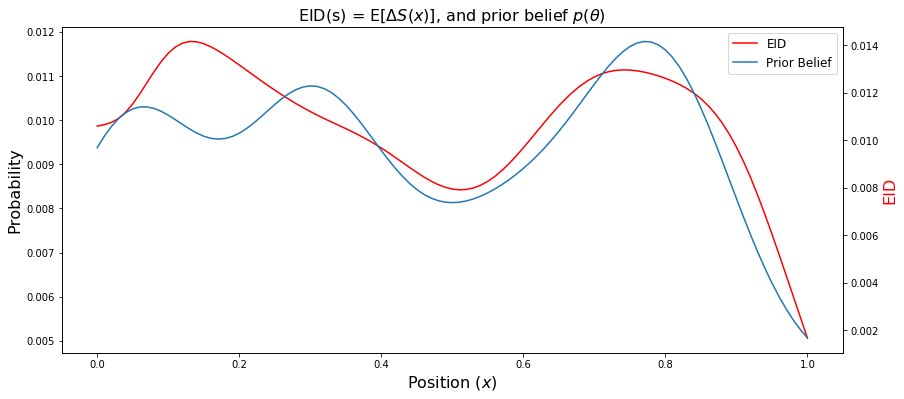

In [7]:
# Construct EER function
def EER(prior, sigmaM=0.1, sigmaL=0.2):
    sBase = entropy(prior)
    deltaS = np.zeros(wsResolution)
    for mms in np.linspace(0,1,wsResolution):
        # Posterior
        pvx, pL = PvxNew(v=mms, prior=prior, sigmaM=sigmaM, sigmaL=sigmaL)
        pp = pL * prior
        # Entropy
        dS = sBase - entropy(pp.T)
        # Update result
        deltaS += pvx * dS
    # Convert deltaS to Entropy EID
    EER_Entropy = deltaS
    EER_Entropy[EER_Entropy == np.inf] = 0
    EER_Entropy[EER_Entropy < 0] = 0
    if abs(EER_Entropy).sum() != 0:
        EER_Entropy /= EER_Entropy.sum()
    
    return EER_Entropy

# Compute base entropy
sMax = entropy(np.ones(wsResolution)/wsResolution)
sBase = entropy(priorP)
print("Maximum possible entropy = {0}".format(sMax))
print("Entropy of current prior = {0}".format(sBase))

# Compute EER map
EER_Entropy = EER(priorP)

# Plot entropy map
# plt.figure(figsize=(14,6))
fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()
h1 = ax1.plot(wsSamples, EER_Entropy, label='EID', color='r')
h2 = ax2.plot(wsSamples, priorP, label='Prior Belief')
h = h1 + h2
lbl = [l.get_label() for l in h]
plt.title(r"EID(s) = E$\left[ \Delta S(x) \right]$, and prior belief $p(\theta)$", fontsize=16)
ax1.set_xlabel("Position ($x$)", fontsize=16)
ax1.set_ylabel("Probability", fontsize=16)
ax2.set_ylabel("EID", fontsize=16, color='r')
plt.legend(h, lbl, fontsize=12);

Evaluating the EID for the shown belief, we can see the expected amount of information for every candidate sensing location in the workspace. Note that the EID indicates that a measurement at $x$ near 0.15 is probably the next best place to take a measurement while $x$ near 0.8 is also a good choice (and might be more convenient depending on the current state $x$).

### Example EID on Different Beliefs

Below, we show EID on 6 different belief distributions including flat, unimodal, and multi-modal distributions.

In [ ]:
## Construct a variety of different prior beliefs and compute the corresponding EID maps
priorP1 = np.ones(wsResolution)/wsResolution  # Flat belief
EID_Entropy1 = EER(priorP1)
print("Prior example 1 - flat - entropy = {0}".format(entropy(priorP1)))

priorP2 = recipinvgauss.pdf(wsSamples+1e-4,0.6,0,0.05)  # Reciprocal inverse Gaussian, centered, low variance
priorP2 /= priorP2.sum()
EID_Entropy2 = EER(priorP2)
print("Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = {0}".format(entropy(priorP2)))

priorP3 = norm.pdf(wsSamples,0.5,0.2)  # Unimodal, centered, high variance
priorP3 /= priorP3.sum()
EID_Entropy3 = EER(priorP3)
print("Prior example 3 - Unimodal, centered, high variance - entropy = {0}".format(entropy(priorP3)))

priorP4 = norm.pdf(wsSamples,0.5,0.09)  # Unimodal, centered, low variance
priorP4 /= priorP4.sum()
EID_Entropy4 = EER(priorP4)
print("Prior example 4 - Unimodal, cornered, low variance - entropy = {0}".format(entropy(priorP4)))

priorP5 = norm.pdf(wsSamples,0.7,0.12) + norm.pdf(wsSamples,0.3,0.12) # Bimodal, centered, high variance
priorP5 /= priorP5.sum()
EID_Entropy5 = EER(priorP5)
print("Prior example 5 - Bimodal, centered, high variance - entropy = {0}".format(entropy(priorP5)))

priorP6 = norm.pdf(wsSamples,0.7,0.06) + norm.pdf(wsSamples,0.3,0.06) # Bimodal, centered, high variance
priorP6 /= priorP6.sum()
EID_Entropy6 = EER(priorP6)
print("Prior example 6 - Bimodal, centered, low variance - entropy = {0}".format(entropy(priorP6)))
   
# Build data list
priorList = [priorP1, priorP2, priorP3, priorP4, priorP5, priorP6]
EIDList = [EID_Entropy1, EID_Entropy2, EID_Entropy3, EID_Entropy4, EID_Entropy5, EID_Entropy6]

## Compare Entropy and Fisher Information on Different Priors
f, axArray = plt.subplots(3, 2, sharex='col', figsize=(15, 12))
axArray = axArray.flatten()
for idx, p in enumerate(priorList):
    axArray[idx].plot(wsSamples, EIDList[idx], label='EID')
    axArray[idx].plot(wsSamples, p, label='Prior Belief')
    axArray[idx].set_xlabel("Position", fontsize=14)
    axArray[idx].set_ylabel("EID", fontsize=14)
    axArray[idx].legend(fontsize=12, loc='best');

Prior example 1 - flat - entropy = 4.6151205168412615
Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = 3.4031070758599844
Prior example 3 - Unimodal, centered, high variance - entropy = 4.361006466387932
Prior example 4 - Unimodal, cornered, low variance - entropy = 3.61616276953873
